In [173]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stat
from scipy.optimize import minimize
import itertools

In [138]:
def single_state_model(A, B, num_trials, p_type):
    rotation_estimate = np.zeros(num_trials)
    error = np.zeros(num_trials)
    if p_type == 'Sudden':
        rotation = np.pi/3
        for trial in range(1, num_trials):
            error[trial-1] = rotation - rotation_estimate[trial-1]
            rotation_estimate[trial] = A*rotation_estimate[trial-1] + B*error[trial-1]
    else:
        rotation = np.pi/18
        for trial in range(1, num_trials):
            error[trial-1] = rotation - rotation_estimate[trial-1]
            rotation_estimate[trial] = A*rotation_estimate[trial-1] + B*error[trial-1]
            if trial%64 == 0:
                if rotation < np.pi/3:
                    rotation = rotation + np.pi/18
    error[trial] = rotation - rotation_estimate[trial]
    return error

In [139]:
def dual_state_model(Af, Bf, As, Bs, num_trials, p_type):
    rotation_estimate = np.zeros(num_trials)
    fast_estimate = np.zeros(num_trials)
    slow_estimate = np.zeros(num_trials)
    
    error = np.zeros(num_trials)
    if p_type == 'Sudden':
        rotation = np.pi/3

        for trial in range(1, num_trials):
            error[trial-1] = rotation - rotation_estimate[trial-1]
            fast_estimate[trial] = Af*fast_estimate[trial-1] + Bf*error[trial-1]
            slow_estimate[trial] = As*slow_estimate[trial-1] + Bs*error[trial-1]
            rotation_estimate[trial] = fast_estimate[trial] + slow_estimate[trial]
            
    else:
        rotation = np.pi/18
        for trial in range(1, num_trials):
            error[trial-1] = rotation - rotation_estimate[trial-1]
            fast_estimate[trial] = Af*fast_estimate[trial-1] + Bf*error[trial-1]
            slow_estimate[trial] = As*slow_estimate[trial-1] + Bs*error[trial-1]
            rotation_estimate[trial] = fast_estimate[trial] + slow_estimate[trial]

            if trial%64 == 0:
                if rotation < np.pi/3:
                    rotation = rotation + np.pi/18
    error[trial] = rotation - rotation_estimate[trial-1]

    return error

In [153]:
def calc_log_likelihood(params, data, model, p_type):
    if model == 'single state':
        if any(params[:-1]) < 0 or any(params) > 1:
            return np.inf
        model_pred = single_state_model(params[0], params[1], len(data), p_type)
    else:
        if any(params[:-1]) < 0 or any(params) > 1 or params[0] > params[2] or params[1] < params[3]:
            return np.inf        
        model_pred = dual_state_model(params[0], params[1], params[2], params[3], len(data), p_type)
    log_lik = sum(stat.norm.logpdf(data, model_pred, params[-1]))
    return -log_lik

In [13]:
data = pd.read_csv('learning_curvature_errors.csv')

In [185]:

def fit_single(participant):
    errors = data.loc[data['p_id'] == participant, 'errors'].values*np.pi/180
    p_type = data.loc[data['p_id'] == participant, 'Rotation'].unique()
    curr_fitval = np.inf
    possible_starting_points = itertools.product(np.linspace(0, 1, 8), np.linspace(0, 1, 8), np.linspace(0, 1, 8))
    for i in possible_starting_points:
        temp_res = minimize(calc_log_likelihood, x0=i, args=(errors, 'single state', p_type), bounds=((0, 1), (0, 1), (0, 1)), method = 'Nelder-Mead')
        if temp_res.fun < curr_fitval:
            res = temp_res
            curr_fitval = res.fun
    return res

c:\Users\tejas\Anaconda3\envs\vma\Lib\site-packages\scipy\stats\_distn_infrastructure.py:2134: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


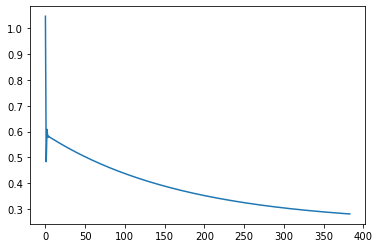